In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import re

import geopandas as gpd
import requests,json


from shapely import geos
from shapely.geometry import Point
import fiona
from fiona.crs import from_epsg,from_string

from geopandas import GeoDataFrame
from shapely.geometry import Polygon
from geopandas import GeoSeries


from shapely import geometry
from shapely.geometry import shape,LineString,Point,Polygon

import osmnx as ox
import networkx as nx

import folium

from folium import IFrame

import seaborn as sns
import branca

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
def rest(address):
    try:
        url = 'https://api.tomtom.com/search/2/geocode/{}.json?&key=h2n93GznJsnsDHtv2vPpdT9GmJijp9o9&countrySet=TWN&language=zh-TW&limit=1'.format(address)
        response = requests.get(url)
        data = response.text
        js = json.loads(str(data))
        return js['results'][0]['position']
    except Exception as e:
        print(f'An Error occurred: {e}')
        return {'lat':0,'lon':0}
    
def trans(gdf):
    gdf.crs = {'init' :'epsg:3824'} # 避免資料沒設，這邊再重新給一次
    gdf=gdf.to_crs({'init' :'epsg:3826'})
    return gdf

def utf2asc(s):
    return str(str(s).encode('ascii', 'xmlcharrefreplace'))[2:-1]

heading3 = """<h3>{}</h3>""".format


def overview(gdf_sub,gdf_little_buffer):
    plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei"]
    plt.rcParams["axes.unicode_minus"] = False

    base = gdf_sub.plot(column='行政區',alpha=0.3,edgecolor='black',figsize=(15, 15),legend=True) #画底图
    gdf_little_buffer.plot(ax=base,color='gray', markersize=5,alpha=0.5)
    #gdf_little.plot(ax=base, color='green')
    plt.gca().xaxis.set_major_locator(plt.NullLocator()) #去掉x轴刻度
    plt.gca().yaxis.set_major_locator(plt.NullLocator()) #去年y轴刻度

In [5]:
gdf=gpd.read_file(r'C:/Users/RT009223/GIS/村里/VILLAGE_MOI_1090423.shp',encoding='utf-8')
gdf=gdf.loc[:,['COUNTYNAME','TOWNNAME','VILLNAME','geometry']]
gdf.crs

<Geographic 2D CRS: EPSG:3824>
Name: TWD97
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Taiwan
- bounds: (114.32, 17.36, 123.61, 26.96)
Datum: Taiwan Datum 1997
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:

gdf=trans(gdf)
print(gdf.shape)
gdf=gdf.dropna().reset_index(drop=True)
gdf.COUNTYNAME=list(gdf.COUNTYNAME.apply(lambda x:x.replace('臺','台')))
print(gdf.shape)
gdf.columns=['縣市','行政區','村里','geometry']
gdf.head()


(7965, 4)
(7760, 4)


,縣市,行政區,村里,geometry
0,高雄市,林園區,中門里,"POLYGON ((184944.359 2488573.475, 184590.382 2..."
1,高雄市,林園區,港埔里,"POLYGON ((185511.383 2488082.466, 185328.939 2..."
2,高雄市,旗津區,上竹里,"POLYGON ((176963.681 2497193.949, 176556.101 2..."
3,高雄市,旗津區,中興里,"POLYGON ((178336.229 2495250.800, 178300.738 2..."
4,連江縣,南竿鄉,津沙村,"POLYGON ((141692.824 2892627.730, 141692.254 2..."


In [7]:
gdf['縣市']=list(gdf['縣市'].apply(lambda x:x.replace('臺','台')))
gdf['行政區']=list(gdf['行政區'].apply(lambda x:x.replace('臺','台')))
gdf['村里']=list(gdf['村里'].apply(lambda x:x.replace('臺','台')))

gdf['村里']=gdf['村里'].apply(lambda x:x.replace('舘','館'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('双','雙'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('石[曹]里','石𥕢里'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('鷄林里','雞林里'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('水磜村','水祭村'))
gdf['村里']=gdf['村里'].apply(lambda x:x.replace('珊湖里','珊瑚里'))

gdf['村里']=gdf['村里'].apply(lambda x:x.replace('欍','瓊'))

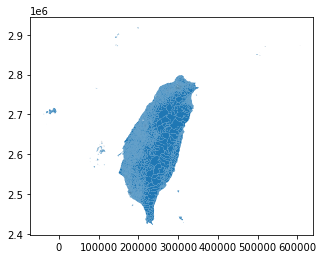

In [52]:
#gdf.plot()

In [53]:
gdf[(gdf['行政區']=='土城區') &(gdf['村里']=='青雲里')]

,縣市,行政區,村里,geometry
6364,新北市,土城區,青雲里,"POLYGON ((296455.537 2764797.990, 296463.096 2..."


In [8]:
TLW=pd.read_excel(r'C:\Users\RT009223\TestriteGroup\滲透率專案\02_adjusted data\HOLA店點.xlsx')
geom=[Point(data.lon,data.lat) for idx, data in TLW.iterrows()]
crs = {'init': 'epsg:4326'}
TLW = gpd.GeoDataFrame(TLW, crs=crs, geometry=geom)
TLW=trans(TLW)

In [72]:
gdf.loc[(gdf['行政區']=='南屯區') &(gdf['村里']=='惠中里'),:]

,縣市,行政區,村里,geometry
5864,台中市,南屯區,惠中里,"POLYGON ((213587.658 2671809.204, 213686.330 2..."


In [73]:
center=gdf.loc[(gdf['行政區']=='南屯區') &(gdf['村里']=='惠中里'),:].copy()
gdf_little_buffer=center.loc[:,['geometry']].copy()
center['near']='0'
gdf_little_buffer

radius=float(1)
gdf_little_buffer['geometry']=gdf_little_buffer.buffer(radius)

intersection = gpd.overlay(gdf,gdf_little_buffer,  how='intersection')
gdf_sub=gdf[(gdf['行政區']+gdf['村里']).isin(intersection['行政區']+intersection['村里']) ].reset_index(drop=True)

gdf_sub2=gdf_sub[-pd.Series(gdf_sub.geometry).isin(pd.Series(center.geometry))]
gdf_sub2['near']='1'
center=pd.concat([center,gdf_sub2]).reset_index(drop=True).sort_values(by='near')

In [74]:
center

,縣市,行政區,村里,geometry,near
0,台中市,南屯區,惠中里,"POLYGON ((213587.658 2671809.204, 213686.330 2...",0
1,台中市,南屯區,南屯里,"POLYGON ((213233.316 2670058.959, 213198.582 2...",1
2,台中市,南屯區,三厝里,"POLYGON ((212474.506 2671501.454, 212769.474 2...",1
3,台中市,南屯區,田心里,"POLYGON ((214094.923 2670675.207, 214095.469 2...",1
4,台中市,南屯區,文心里,"POLYGON ((214303.172 2671323.205, 214351.153 2...",1
5,台中市,南屯區,三和里,"POLYGON ((212437.024 2671605.598, 212435.537 2...",1
6,台中市,南屯區,三義里,"POLYGON ((213454.549 2671820.953, 213332.065 2...",1
7,台中市,西區,公正里,"POLYGON ((214950.991 2671728.671, 214951.185 2...",1
8,台中市,南屯區,溝墘里,"POLYGON ((214407.171 2672299.202, 214408.054 2...",1
9,台中市,南屯區,大業里,"POLYGON ((214821.388 2672321.113, 214788.061 2...",1


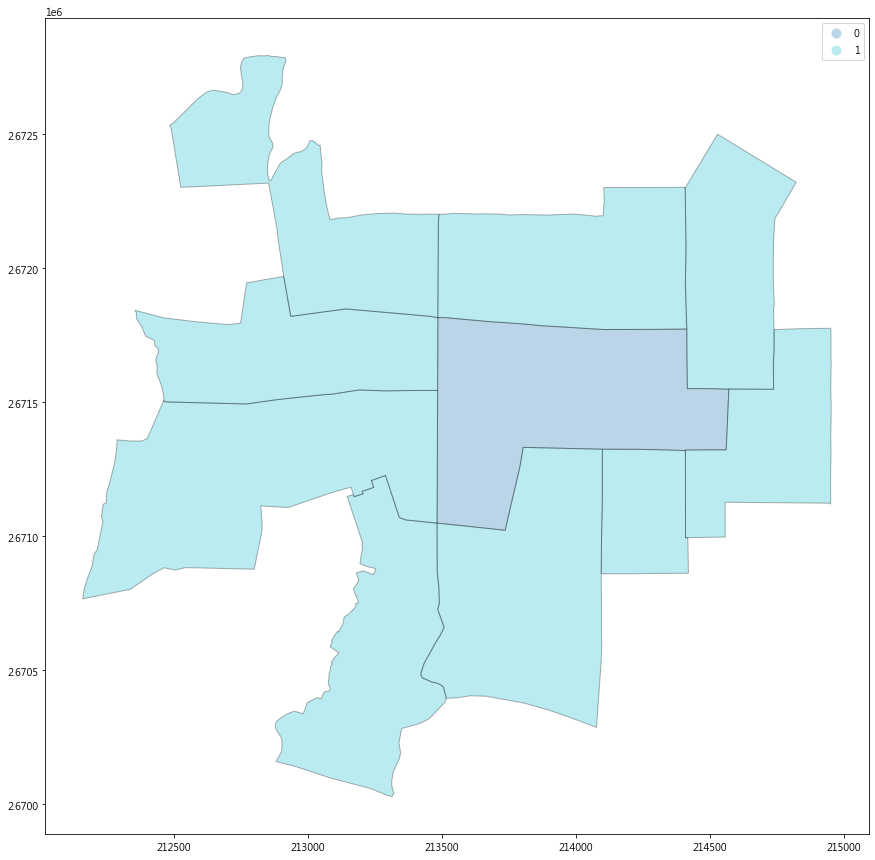

In [75]:
base = center.plot(column='near',alpha=0.3,edgecolor='black',figsize=(15, 15),legend=True) #画底图
base

In [78]:
lv='3'

gdf_little_buffer=center.loc[:,['geometry']].copy()
#print(gdf_little_buffer)

radius=float(1)
gdf_little_buffer['geometry']=gdf_little_buffer.buffer(radius)

intersection = gpd.overlay(gdf,gdf_little_buffer,  how='intersection')
gdf_sub=gdf[(gdf['行政區']+gdf['村里']).isin(intersection['行政區']+intersection['村里']) ].reset_index(drop=True)

gdf_sub2=gdf_sub[-gdf_sub.geometry.isin(center.geometry)]
gdf_sub2['near']=lv
center=pd.concat([center,gdf_sub2]).reset_index(drop=True).sort_values(by='near')

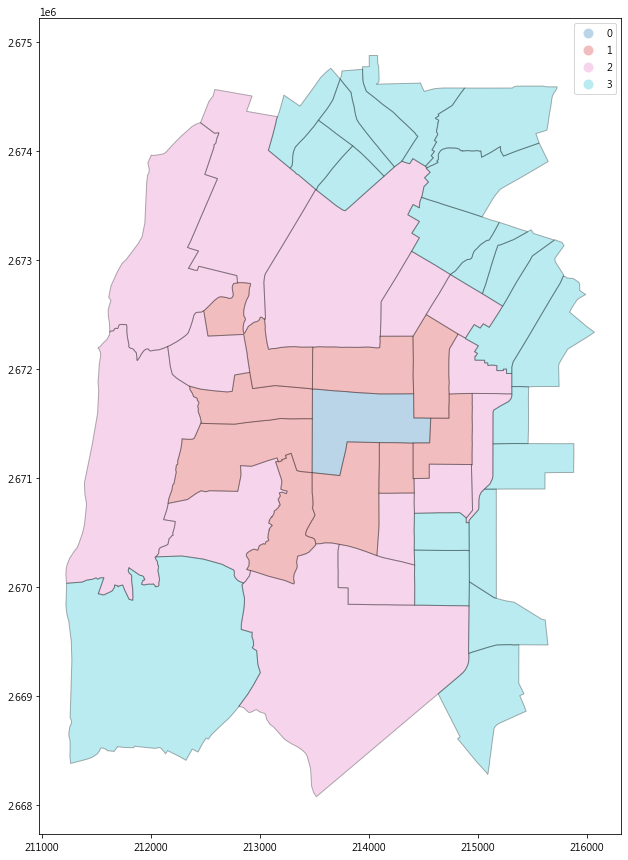

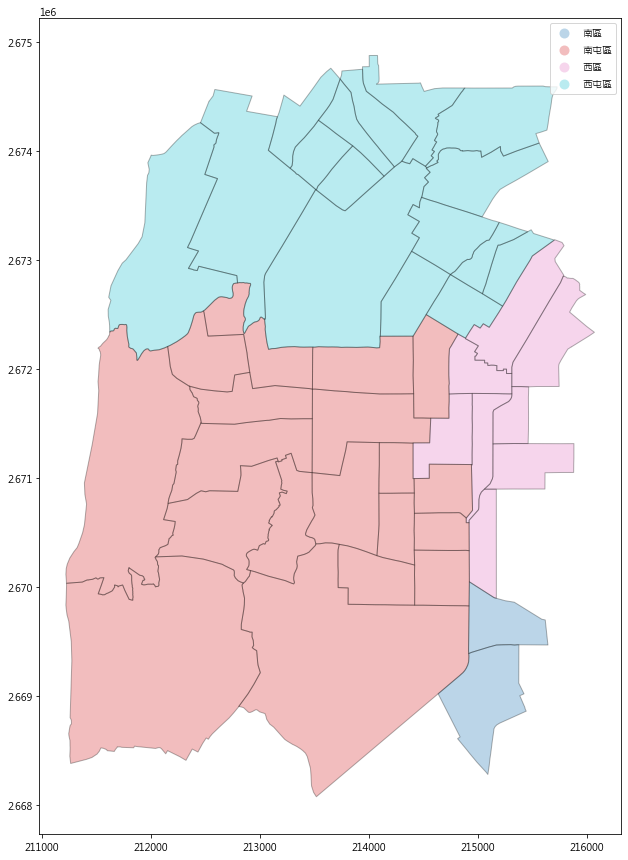

In [87]:
plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei"]
plt.rcParams["axes.unicode_minus"] = False
base = center.plot(column='near',alpha=0.3,edgecolor='black',figsize=(15, 15),legend=True) #画底图
base
base2 = center.plot(column='行政區',alpha=0.3,edgecolor='black',figsize=(15, 15),legend=True) #画底图
base2

In [83]:
TLW[TLW.name=='大墩店']

,name,addr,type,lat,lon,geometry
2,大墩店,台中市南屯區大墩路533號1F,0,24.149572,120.64965,POINT (214396.001 2671632.494)


In [86]:
center=center[center.geometry.boundary.distance(TLW.geometry[2])<2500].reset_index(drop=True)

In [68]:
center=center[center['行政區'].isin(['大雅區','西屯區','龍井區'])].reset_index(drop=True)

In [70]:
center

,縣市,行政區,村里,geometry,near
0,台中市,西屯區,福安里,"POLYGON ((212011.428 2675516.191, 212190.787 2...",0
1,台中市,西屯區,西墩里,"POLYGON ((212674.270 2675321.692, 212675.481 2...",1
2,台中市,西屯區,福和里,"POLYGON ((210925.197 2674356.962, 210928.057 2...",1
3,台中市,西屯區,福雅里,"POLYGON ((211387.383 2675102.193, 211368.821 2...",1
4,台中市,西屯區,永安里,"POLYGON ((208801.172 2677227.185, 208952.922 2...",1
5,台中市,西屯區,港尾里,"POLYGON ((214622.493 2678301.351, 214639.790 2...",2
6,台中市,西屯區,福中里,"POLYGON ((210971.986 2674441.338, 210971.914 2...",2
7,台中市,西屯區,西安里,"POLYGON ((213222.409 2674513.945, 213222.817 2...",2
8,台中市,西屯區,龍潭里,"POLYGON ((212180.843 2672218.738, 212174.221 2...",2
9,台中市,西屯區,西平里,"POLYGON ((213597.455 2674812.194, 213629.764 2...",2


In [88]:
center.to_excel(r'D:\Users\RT009223\Desktop\HOLA大墩店.xlsx')

In [334]:
center.geometry.boundary

0     LINESTRING (217870.516 2652734.750, 217949.984...
1     LINESTRING (217598.766 2652749.000, 217751.812...
2     LINESTRING (218369.766 2652448.750, 218521.984...
3     LINESTRING (218597.594 2652482.500, 218583.188...
4     LINESTRING (217770.797 2652915.750, 217865.922...
5     LINESTRING (216437.172 2654115.750, 216479.641...
6     LINESTRING (218154.531 2653468.750, 218127.531...
7     LINESTRING (220933.109 2653218.500, 220920.656...
8     LINESTRING (217612.831 2650875.355, 217596.761...
9     LINESTRING (218301.125 2653480.000, 218333.328...
10    LINESTRING (219377.949 2651150.905, 219376.596...
11    LINESTRING (220082.141 2655637.749, 220127.530...
12    LINESTRING (215489.969 2654078.000, 215547.250...
13    LINESTRING (218139.906 2650103.250, 218172.312...
14    LINESTRING (216603.906 2652546.500, 216606.346...
15    LINESTRING (216127.897 2650946.570, 216220.657...
16    LINESTRING (223047.844 2654672.750, 223094.828...
17    LINESTRING (217831.269 2656353.401, 218054

In [332]:
center.geometry.boundary.distance(TLW.geometry[15])

0       12.350656
1      205.752941
2      109.260313
3       12.350656
4      366.358390
5      608.486292
6      462.212222
7      446.349986
8      772.369410
9      480.416510
10     613.963728
11     978.771706
12    1588.136937
13    2134.304834
14    1295.724987
15    2024.250747
16    2805.111573
17    1173.827765
18    2557.386611
19    1776.342190
20    1628.220386
21    1494.870782
22    2804.785288
23    2414.974808
24    2873.785840
25    1918.889026
dtype: float64

In [350]:
t1 = Polygon([(10,10), (10,0), (50,50), (20,10)])
t = gpd.GeoSeries(t1)
t.crs = 4326

t2 = gpd.GeoSeries([Point(0,0)])
t2.crs = 4326

In [351]:
dist = t.distance(t2)
print(dist)

0    10.0
dtype: float64


In [352]:
dist = t.boundary.distance(t2)
print(dist)

0    10.0
dtype: float64
